In [1]:
# Modifying the provided 'edited-model.py' to incorporate suggested improvements

# Modified script content with additional tuning, early stopping, and class distribution checks.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorboard import notebook

In [2]:
# Load the data
df = pd.read_csv('C:/Users/honey/Documents/placment work/Electronical-AI-Device-Recogniser/khanya/data managment/datasets/acs-f2-dataset.csv')

In [3]:
# Data Preprocessing
df = df.drop('time', axis=1)

# Convert categorical labels to numeric
le = LabelEncoder()
df['equipment'] = le.fit_transform(df['equipment'])

# Split features and labels
X = df.drop('equipment', axis=1)
y = df['equipment']

# Analyze class distribution before SMOTE
print("Class distribution before SMOTE:")
print(y.value_counts())

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

Class distribution before SMOTE:
equipment
3     9682
5     9388
7     9378
6     9348
2     9272
14    9155
13    9088
8     9015
11    9004
4     8849
12    8810
9     8784
10    8755
1     8688
0     8661
Name: count, dtype: int64


In [4]:
# Analyze class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# One-hot encode the target labels
num_classes = len(np.unique(y))
y_resampled_onehot = to_categorical(y_resampled, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_onehot, test_size=0.2, random_state=42)

Class distribution after SMOTE:
equipment
0     9682
1     9682
2     9682
3     9682
4     9682
5     9682
6     9682
7     9682
8     9682
9     9682
10    9682
11    9682
12    9682
13    9682
14    9682
Name: count, dtype: int64


In [13]:
from tensorflow.keras.layers import Input, Concatenate, Multiply
from tensorflow.keras import backend as K

# Define the model architecture with weighted input for 'freq' column and dropout
input_layer = Input(shape=(X_train.shape[1],))
freq_weight = K.constant([[2.0]])  # Convert the weight to a tensor with the same shape as freq_input

# Split the input into 'freq' and other features
freq_input = input_layer[:, 0:1]
other_features = input_layer[:, 1:]

# Apply the weight to the 'freq' column
weighted_freq = Multiply()([freq_input, freq_weight])

# Concatenate the weighted 'freq' column back with the other features
weighted_input = Concatenate()([weighted_freq, other_features])

# Define the rest of the model
x = Dense(128, activation='relu')(weighted_input)
x = Dropout(0.3)(x)  # Increased dropout for stronger regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate for better generalization
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping])


Epoch 1/100
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2997 - loss: 2.0841 - val_accuracy: 0.4541 - val_loss: 1.5440
Epoch 2/100
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4394 - loss: 1.5919 - val_accuracy: 0.5069 - val_loss: 1.3531
Epoch 3/100
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4887 - loss: 1.4297 - val_accuracy: 0.5517 - val_loss: 1.2247
Epoch 4/100
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5225 - loss: 1.3281 - val_accuracy: 0.5880 - val_loss: 1.1408
Epoch 5/100
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5504 - loss: 1.2512 - val_accuracy: 0.6162 - val_loss: 1.0780
Epoch 6/100
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5666 - loss: 1.1964 - val_accuracy: 0.6371 - val_loss: 1.0279
Epoch 7/100
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5810 - loss: 1.1525 - val_accuracy: 0.6461 - val_loss: 0.9887
Epoch 8/100
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5928 - loss: 1

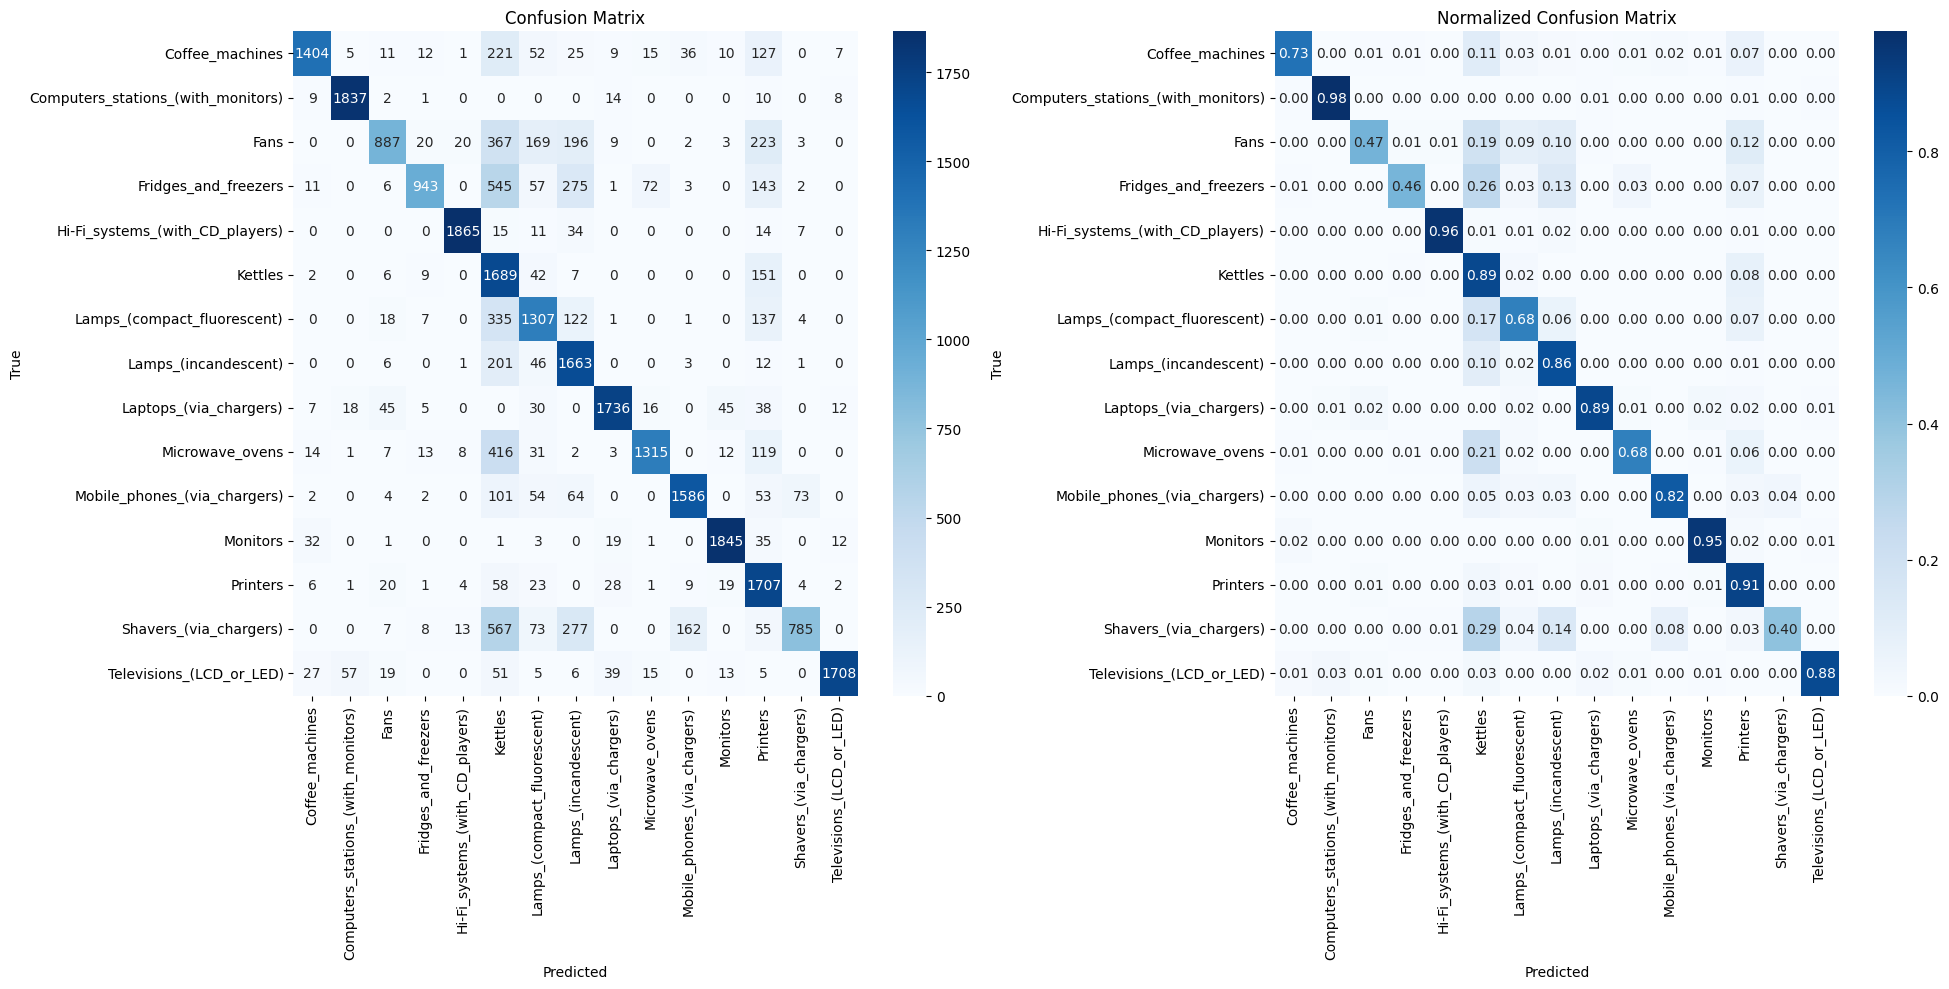

In [10]:
# Define the class names
class_names = le.classes_

# Plot the confusion matrix with labels
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


In [14]:
# Save the trained model and the scaler for future use
model.save('new-model1.0.1.keras')
joblib.dump(scaler, 'new-scaler1.0.1.pkl')

['new-scaler1.0.1.pkl']

In [15]:
  # Return the new path so the user can download it